# Week 8: Classificatiemodellen in Machine Learning

## Bibliotheken importeren

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import pyodbc
import matplotlib.pyplot as plt

## Data inlezen en kolommen selecteren

In [48]:
DB_DWH = {"servername": r"localhost,1433", "database": "dwh", "username": "sa", "password": "iDTyjZx7dRL4"}

dwh_conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={DB_DWH['servername']};"
    f"DATABASE={DB_DWH['database']};"
    f"UID={DB_DWH['username']};"
    f"PWD={DB_DWH['password']}"
)



In [49]:
def create_dataframes_sql(connection):
    dictionary : dict = {}
    query : str = ""
    key : str = ""

    query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
    key = "TABLE_NAME"

    table_names = pd.read_sql(query, connection)

    for table in table_names[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)

    return dictionary

dwh = create_dataframes_sql(dwh_conn)

print(list(dwh.keys()))

/var/folders/k4/8yvf4x0n4c15r7pl4lwy8x6m0000gp/T/ipykernel_9573/506354042.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  table_names = pd.read_sql(query, connection)
/var/folders/k4/8yvf4x0n4c15r7pl4lwy8x6m0000gp/T/ipykernel_9573/506354042.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)


['sales_staff', 'retailer_site', 'product', 'inventory_levels', 'order_details']


In [50]:
order_details = dwh['order_details'].loc[:, ['PRODUCT_NUMBER', 'SALES_STAFF_CODE', 'QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'REVENUE', 'TOTAL_COST', 'RETAILER_SITE_CODE', 'RETAILER_CONTACT_CODE', 'RETURN_QUANTITY', 'RETURN_REASON_CODE']]
order_details = order_details[order_details['RETURN_REASON_CODE'].notna()]
order_details

,PRODUCT_NUMBER,SALES_STAFF_CODE,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,REVENUE,TOTAL_COST,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,RETURN_QUANTITY,RETURN_REASON_CODE
6,1,51,104,4.380000,6.590000,6.590000,685.359985,455.520020,17,73,104.0,3.0
18,2,49,44,9.640000,12.530000,12.530000,551.320007,424.160004,6,66,4.0,2.0
30,4,50,84,5.230000,7.320000,6.800000,571.200012,439.320007,17,73,6.0,2.0
39,5,50,52,38.400002,54.930000,54.930000,2856.360107,1996.800049,18,74,52.0,3.0
46,6,51,20,92.000000,129.720001,129.720001,2594.399902,1840.000000,20,17,20.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37631,13,96,106,392.570007,529.979980,461.290009,48896.742188,41612.421875,335,320,10.0,2.0
37656,30,96,94,6.750000,13.500000,13.500000,1269.000000,634.500000,335,320,10.0,1.0
37657,31,96,240,7.500000,15.000000,13.840000,3321.600098,1800.000000,335,320,8.0,2.0
37686,60,96,82,10.000000,20.000000,15.000000,1230.000000,820.000000,335,320,4.0,1.0


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [ ]:
# order_details['RETURN_REASON_CODE'] = order_details['RETURN_REASON_CODE'].astype(str)
# order_details.dtypes

PRODUCT_NUMBER             int64
SALES_STAFF_CODE           int64
QUANTITY                   int64
UNIT_COST                float64
UNIT_PRICE               float64
UNIT_SALE_PRICE          float64
REVENUE                  float64
TOTAL_COST               float64
RETAILER_SITE_CODE         int64
RETAILER_CONTACT_CODE      int64
RETURN_QUANTITY          float64
RETURN_REASON_CODE        object
dtype: object

In [ ]:
# dummies_dataframe = pd.get_dummies(order_details.loc[:, ['RETURN_REASON_CODE']])
# dummies_dataframe

,RETURN_REASON_CODE_1.0,RETURN_REASON_CODE_2.0,RETURN_REASON_CODE_3.0,RETURN_REASON_CODE_4.0,RETURN_REASON_CODE_5.0
6,False,False,True,False,False
18,False,True,False,False,False
30,False,True,False,False,False
39,False,False,True,False,False
46,False,False,False,True,False
...,...,...,...,...,...
37631,False,True,False,False,False
37656,True,False,False,False,False
37657,False,True,False,False,False
37686,True,False,False,False,False


In [ ]:
# order_details = pd.concat([order_details, dummies_dataframe], axis = 1)
# order_details = order_details.loc[order_details['RETURN_REASON_CODE'].notna(), ['PRODUCT_NUMBER', 'SALES_STAFF_CODE', 'QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'REVENUE', 'TOTAL_COST', 'RETAILER_SITE_CODE', 'RETAILER_CONTACT_CODE', 'RETURN_QUANTITY', 'RETURN_REASON_CODE_1.0', 'RETURN_REASON_CODE_2.0', 'RETURN_REASON_CODE_3.0', 'RETURN_REASON_CODE_4.0', 'RETURN_REASON_CODE_5.0']]
# order_details

,PRODUCT_NUMBER,SALES_STAFF_CODE,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,REVENUE,TOTAL_COST,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,RETURN_QUANTITY,RETURN_REASON_CODE_1.0,RETURN_REASON_CODE_2.0,RETURN_REASON_CODE_3.0,RETURN_REASON_CODE_4.0,RETURN_REASON_CODE_5.0
6,1,51,104,4.380000,6.590000,6.590000,685.359985,455.520020,17,73,104.0,False,False,True,False,False
18,2,49,44,9.640000,12.530000,12.530000,551.320007,424.160004,6,66,4.0,False,True,False,False,False
30,4,50,84,5.230000,7.320000,6.800000,571.200012,439.320007,17,73,6.0,False,True,False,False,False
39,5,50,52,38.400002,54.930000,54.930000,2856.360107,1996.800049,18,74,52.0,False,False,True,False,False
46,6,51,20,92.000000,129.720001,129.720001,2594.399902,1840.000000,20,17,20.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37631,13,96,106,392.570007,529.979980,461.290009,48896.742188,41612.421875,335,320,10.0,False,True,False,False,False
37656,30,96,94,6.750000,13.500000,13.500000,1269.000000,634.500000,335,320,10.0,True,False,False,False,False
37657,31,96,240,7.500000,15.000000,13.840000,3321.600098,1800.000000,335,320,8.0,False,True,False,False,False
37686,60,96,82,10.000000,20.000000,15.000000,1230.000000,820.000000,335,320,4.0,True,False,False,False,False


## Horizontaal en verticaal snijden

In [51]:
X = order_details.drop('RETURN_REASON_CODE', axis = 1)
y = order_details.loc[:, ['RETURN_REASON_CODE']]
X

,PRODUCT_NUMBER,SALES_STAFF_CODE,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,REVENUE,TOTAL_COST,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,RETURN_QUANTITY
6,1,51,104,4.380000,6.590000,6.590000,685.359985,455.520020,17,73,104.0
18,2,49,44,9.640000,12.530000,12.530000,551.320007,424.160004,6,66,4.0
30,4,50,84,5.230000,7.320000,6.800000,571.200012,439.320007,17,73,6.0
39,5,50,52,38.400002,54.930000,54.930000,2856.360107,1996.800049,18,74,52.0
46,6,51,20,92.000000,129.720001,129.720001,2594.399902,1840.000000,20,17,20.0
...,...,...,...,...,...,...,...,...,...,...,...
37631,13,96,106,392.570007,529.979980,461.290009,48896.742188,41612.421875,335,320,10.0
37656,30,96,94,6.750000,13.500000,13.500000,1269.000000,634.500000,335,320,10.0
37657,31,96,240,7.500000,15.000000,13.840000,3321.600098,1800.000000,335,320,8.0
37686,60,96,82,10.000000,20.000000,15.000000,1230.000000,820.000000,335,320,4.0


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state=42
)

In [53]:
list(X.columns)

['PRODUCT_NUMBER',
 'SALES_STAFF_CODE',
 'QUANTITY',
 'UNIT_COST',
 'UNIT_PRICE',
 'UNIT_SALE_PRICE',
 'REVENUE',
 'TOTAL_COST',
 'RETAILER_SITE_CODE',
 'RETAILER_CONTACT_CODE',
 'RETURN_QUANTITY']

## Decision Tree bouwen en evalueren

### Max_depth = 2

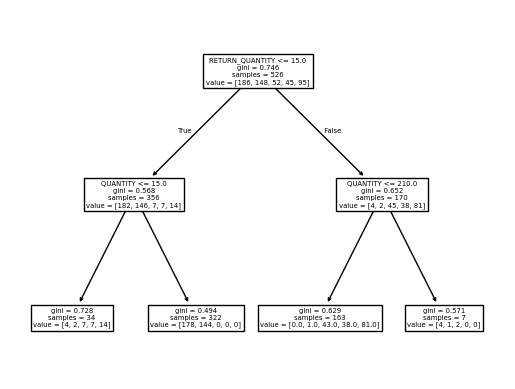

In [54]:
dtree = DecisionTreeClassifier(max_depth = 2)
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [32]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,Predicted_Return_Reason
0,3.0,5.0
1,3.0,5.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
88,2.0,1.0
89,1.0,1.0
90,1.0,1.0
91,1.0,1.0


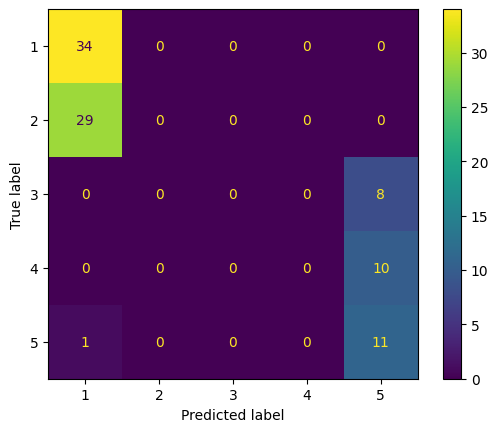

In [55]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [56]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Return_Reason'])

0.4838709677419355

### Max_depth = 3

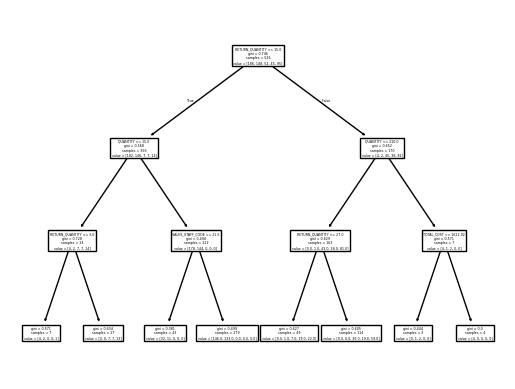

In [68]:
dtree = DecisionTreeClassifier(max_depth = 3)
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [69]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,Predicted_Return_Reason
0,3.0,5.0
1,3.0,5.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
88,2.0,1.0
89,1.0,1.0
90,1.0,1.0
91,1.0,1.0


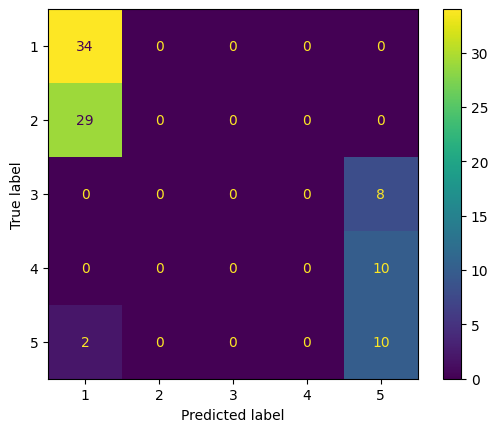

In [70]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [66]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Return_Reason'])

0.4838709677419355

### Geen Max_depth

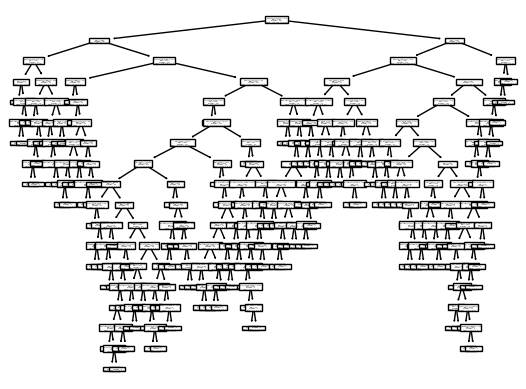

In [71]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

## Evalueren

In [72]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,Predicted_Return_Reason
0,3.0,5.0
1,3.0,5.0
2,1.0,2.0
3,1.0,1.0
4,1.0,1.0
...,...,...
88,2.0,1.0
89,1.0,1.0
90,1.0,1.0
91,1.0,2.0


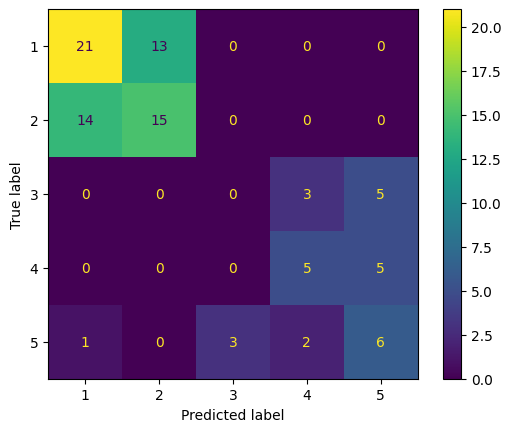

In [73]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [65]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_Return_Reason'])

0.4838709677419355